In [92]:
import tensorflow as tf
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('darkgrid')

In [93]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [94]:
def get_layers_output(fcs, layer_size, init_w, activation_func):
    n = len(layer_size)
    for i in range(0, n - 1):
        X = fcs[i]
        node_in = layer_size[i]
        node_out = layer_size[i + 1]
        W = tf.Variable( init_w(shape=(node_in, node_out)) )
        fc = tf.matmul(X, W)
        fc = activation_func(fc)
        fcs.append(fc)

def get_layers_output_bn(fcs, layer_size, init_w, activation_func):
    n = len(layer_size)
    for i in range(0, n - 1):
        X = fcs[i]
        node_in = layer_size[i]
        node_out = layer_size[i + 1]
        W = tf.Variable( init_w(shape=(node_in, node_out)) )
        fc = tf.matmul(X, W)
        fc = activation_func(fc)
        bn_mean, bn_var = tf.nn.moments(fc, axes=[0])
        fc = tf.nn.batch_normalization(fc, bn_mean, bn_var, 0, 1, 1e-7)
        fc = activation_func(fc)
        fcs.append(fc)

def plot_layers_output(fcs):
    plot_layers_output.counter += 1
    n = len(fcs)

    plt.figure(plot_layers_output.counter)
    fig, axes = plt.subplots(1, n, sharex=True, sharey=True, figsize=(n, 5))
    fig.suptitle('output')
    for i in range(0, n):
        d = tf.reshape(fcs[i], (-1)).numpy()
        filtered = d[(d >= -2) & (d <= 2)]
        sns.histplot(data=filtered, ax=axes[i], binwidth=0.3)
        axes[i].set_xlabel(f'layer {i}')
plot_layers_output.counter = -1

In [95]:
num_records = 2000
num_units = 100
num_layers = 10
np.random.seed(42)
data = tf.constant(np.random.randn(num_records, num_units), dtype='float32')
layer_size = [num_units for i in range(0, num_layers)]

### Tanh with initial weight of normal distribution

If the variance of output is less than one, as the number of layers increases the output rapidly approach zero which can lead to vanishing gradient.

<Figure size 432x288 with 0 Axes>

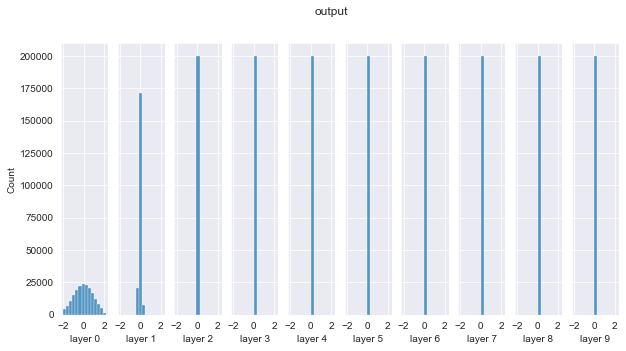

In [96]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01)
get_layers_output(fcs, layer_size, initializer, tf.nn.tanh)
plot_layers_output(fcs)

We can observe that the output shape is good when std = 0.1 . The reason is that std = 0.1 happens to be 1 / sqrt(number_of_input). In fact, it is Xavier distribution which makes the variance of ouput equal to 1.

<Figure size 432x288 with 0 Axes>

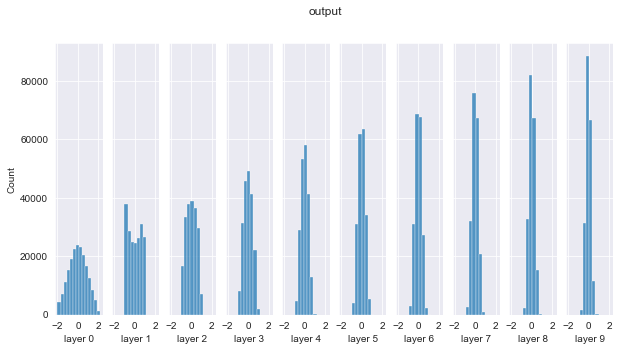

In [97]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1)
get_layers_output(fcs, layer_size, initializer, tf.nn.tanh)
plot_layers_output(fcs)

We set the std of the initial weight to 1. The value of the output are centered at 1 and -1.

Tanh can prevent exploding gradient.

<Figure size 432x288 with 0 Axes>

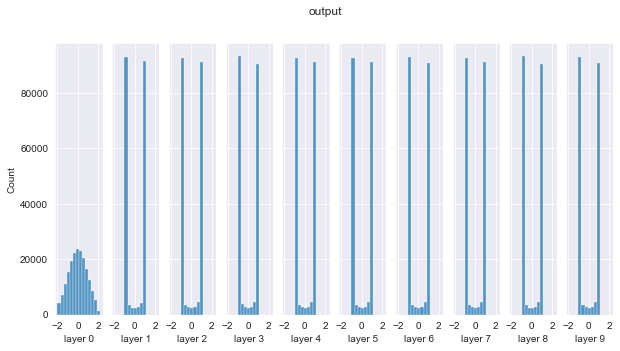

In [98]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1)
get_layers_output(fcs, layer_size, initializer, tf.nn.tanh)
plot_layers_output(fcs)

However, the ouput is either 1 or -1 which is the
case that the neuron saturated.

We can conclude that normal distribution is not
suitable for Tanh activation function.

### Tanh with initial weight of Xavier (Glorot) distribution

y = wx + b

If the variance of x equals to 1 and w is in Xavier distribution, the variance of y equals to 1.

<Figure size 432x288 with 0 Axes>

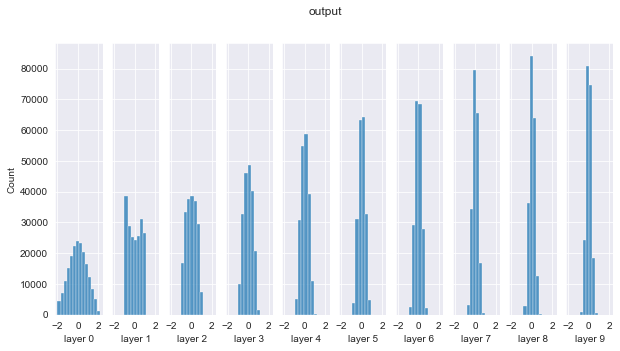

In [99]:
fcs = [data]
initializer = tf.keras.initializers.GlorotNormal()
get_layers_output(fcs, layer_size, initializer, tf.nn.tanh)
plot_layers_output(fcs)

### ReLU with initial weight of normal distribution

<Figure size 432x288 with 0 Axes>

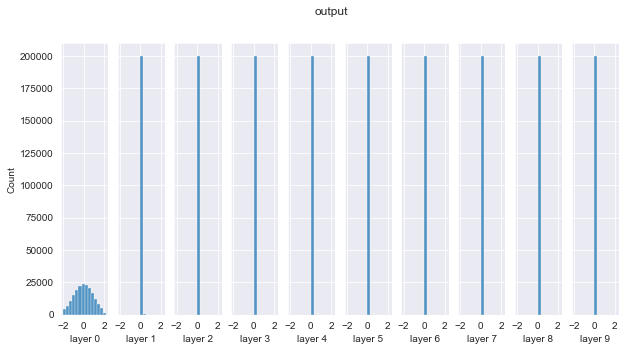

In [100]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01)
get_layers_output(fcs, layer_size, initializer, tf.nn.relu)
plot_layers_output(fcs)

<Figure size 432x288 with 0 Axes>

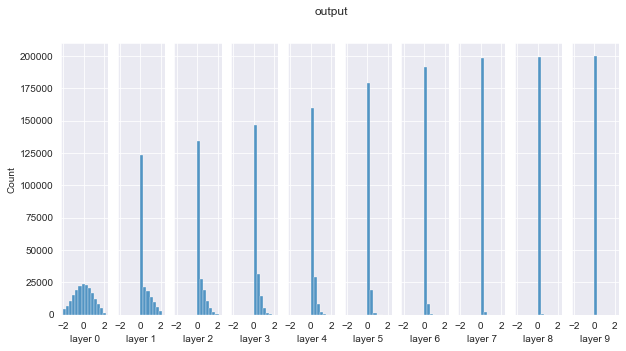

In [101]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1)
get_layers_output(fcs, layer_size, initializer, tf.nn.relu)
plot_layers_output(fcs)

The output value explodes exponentially as the layer increases which resulting in exploding gradients.

In [102]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1)
get_layers_output(fcs, layer_size, initializer, tf.nn.relu)
#plot_layers_output(fcs)
fcs[-1][0][0]

<tf.Tensor: shape=(), dtype=float32, numpy=36946190.0>

### ReLU with initial weight of Xavier (Glorot) distribution

The output approaches zero, as the layer increases.

<Figure size 432x288 with 0 Axes>

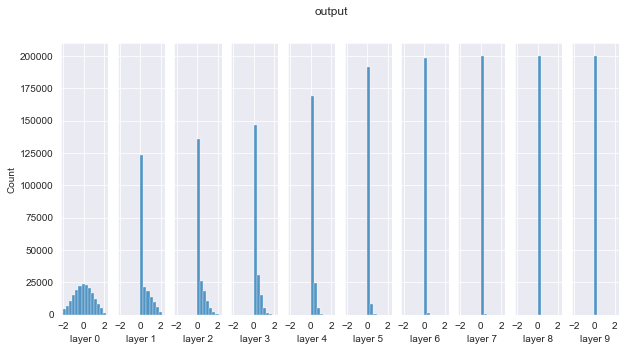

In [103]:
fcs = [data]
initializer = tf.keras.initializers.GlorotNormal()
get_layers_output(fcs, layer_size, initializer, tf.nn.relu)
plot_layers_output(fcs)

### ReLU with initial weight of He distribution

y = wx

Var(y) = Var(w<sub>1</sub>x<sub>1</sub>) + ... + Var(w<sub>n</sub>x<sub>n</sub>)

But for y = relu(wx), half of the neurons output 0, so we need to devide the variance by 1 / sqrt(0.5 x number_of_input) to make the variance equal to 1.

<Figure size 432x288 with 0 Axes>

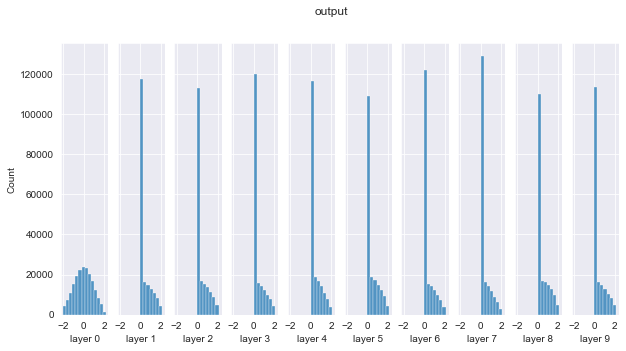

In [104]:
fcs = [data]
initializer = tf.keras.initializers.HeNormal()
get_layers_output(fcs, layer_size, initializer, tf.nn.relu)
plot_layers_output(fcs)

### Batch Normalization

![](bn.PNG)

In training phase, we use batch mean and batch variance. At the same time, we update running mean and runing variance.

![](running.PNG)

In testing phase, we use running mean and runing variance.

Batch normalization makes the variance of the output equal to 1. In this case, the distribution of initial weight doesn't matter any more. It can prevent expoding and vanishing outputs.

<Figure size 432x288 with 0 Axes>

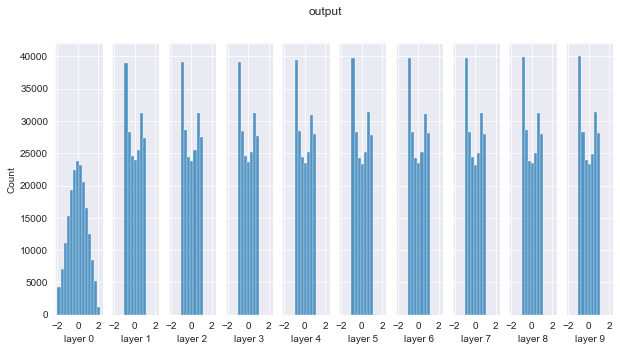

In [105]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01)
get_layers_output_bn(fcs, layer_size, initializer, tf.nn.tanh)
plot_layers_output(fcs)

<Figure size 432x288 with 0 Axes>

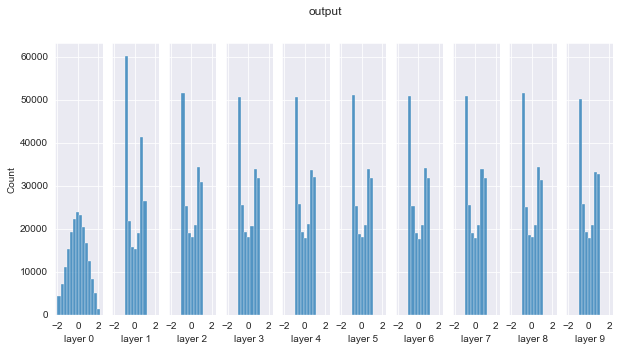

In [106]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1)
get_layers_output_bn(fcs, layer_size, initializer, tf.nn.tanh)
plot_layers_output(fcs)

<Figure size 432x288 with 0 Axes>

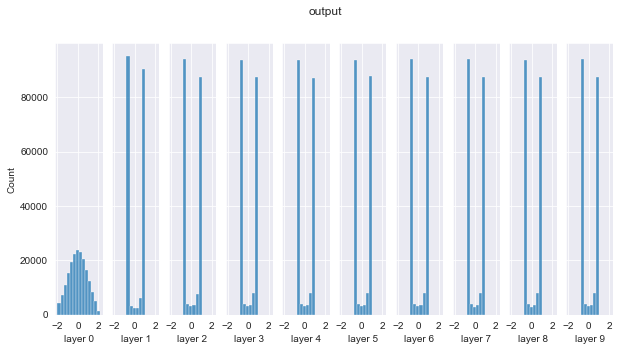

In [107]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
get_layers_output_bn(fcs, layer_size, initializer, tf.nn.tanh)
plot_layers_output(fcs)

<Figure size 432x288 with 0 Axes>

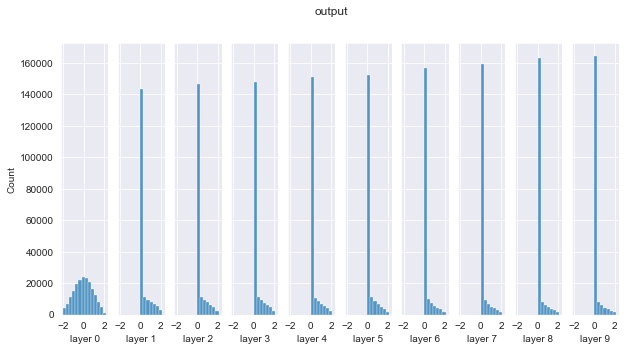

In [108]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.01)
get_layers_output_bn(fcs, layer_size, initializer, tf.nn.relu)
plot_layers_output(fcs)

<Figure size 432x288 with 0 Axes>

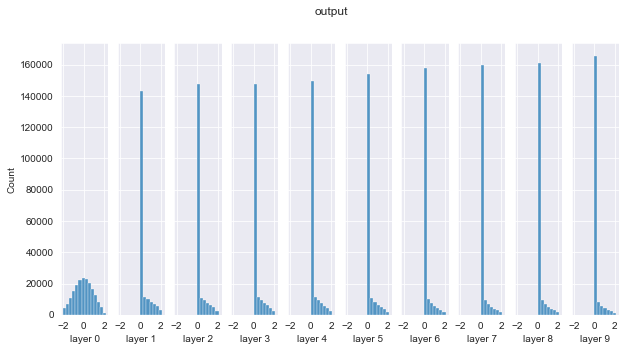

In [109]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=0.1)
get_layers_output_bn(fcs, layer_size, initializer, tf.nn.relu)
plot_layers_output(fcs)

<Figure size 432x288 with 0 Axes>

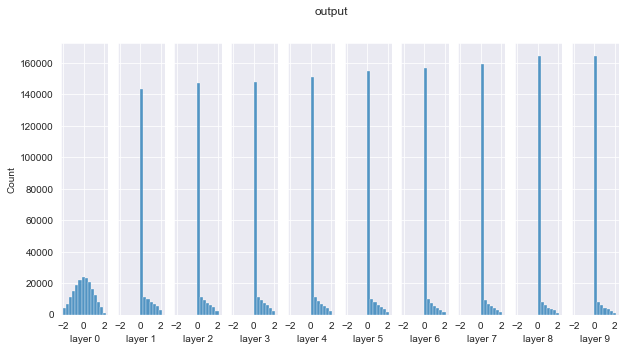

In [112]:
fcs = [data]
initializer = tf.keras.initializers.RandomNormal(mean=0., stddev=1.)
get_layers_output_bn(fcs, layer_size, initializer, tf.nn.relu)
plot_layers_output(fcs)